#Dependencies

In order to implement our various research methods, we will need to use the following libraries.

In [1]:
# import statements

from google.colab import drive  # We import drive so that we can mount our Bitcamp2023 drive to the Colab environment
drive.mount('/content/drive') # this command is how we tell google we have permission to access the data on drive
import pickle # Use to download pkl dataframe files from drive
import pandas as pd # Pandas for manipulating dataframes
import os
from sklearn.model_selection import train_test_split
import shutil # Bringing files into drive
from PIL import Image, ImageOps # Used for image processing operations
import keras
import torch
import torchvision
from torchvision import transforms
import tensorflow as tf
from keras.preprocessing import image
import numpy as np  # Numpy; for efficient calculations
from keras.applications.imagenet_utils import preprocess_input # Used for training and prediction processes with models, filters images to desired criteria 

#AlexNet imports
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

from tqdm.auto import tqdm

Mounted at /content/drive
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3588, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 3588 (delta 94), reused 198 (delta 87), pack-reused 3378
Receiving objects: 100% (3588/3588), 647.36 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (2050/2050), done.
Updating files: 100% (243/243), done.


In [2]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.2 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [3]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


In [4]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#Data Preparation

**Creating dataframe containing information corresponding with each image we will be using for testing and training. Also bringing in images from Snapshots and NonPolarLowSnapshots folders to our Polar Home Depot folder**

NOTE: These images were later moved into different folders because we wanted to reorganize our directories. 

In [5]:
# Read in of dataframe for Spring 2020, 2021, and 2022
# File paths for each pickle file
#this includes all of the clean images of size 1000 x 1000 pixels
pickle_path = '/content/drive/My Drive/Bitcamp2023/pkl_file.pkl'

#loads the dataframe in the pickle file into our dataframe
with open(pickle_path, 'rb') as f:
  df = pickle.load(f)

df.head()

,date of Polar Low Occurance,Aqua or Terra?,"How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]",latitude of box top,longitude of box right side,latitude of box bottom,longitude of box left side,file name of PNG
0,08/11/2020,Terra,2,-57.94,-144.555,-66.748,-153.348,200811_HS1.png
1,08/11/2020,Terra,2,-58.15,-130.430,-66.980,-139.220,200811_HS2.png
2,08/10/2020,Terra,2,-51.66,-143.260,-60.430,-152.060,200810_HS1.png
3,08/13/2020,Terra,2,-53.31,-58.410,-62.110,-67.230,200813_HS1.png
4,08/14/2020,Terra,2,-59.40,-79.760,-68.260,-88.580,200814_HS1.png


We took previous semesters filtered pickle files and used the image files in the pickle files to create polar low and non polar low lists

the images that were listed in the pickle file were in the shapshot and Nonpolar low snapshot folder in our google drive. We took those images and put them into 2 lists, PL_files and NPL_files. We then used the lists to organize the image files into our drive into polar low and non polar low image folders. We commented out the code to create the folders so that it would not create new folders within the drive every time we run the code. We will later use these images as our testing and training data for our model. 

In [6]:
# Gather file names of all image files in Google Drive. We want to have files only of file names provided in our data frame.
og_PL_images = os.listdir('/content/drive/My Drive/Bitcamp2023/Polar Lows/')
og_NPL_images = os.listdir('/content/drive/My Drive/Bitcamp2023/Non Polar Lows/')
images = df['file name of PNG'].tolist()
PL_images = []
NPL_images = []
for i in range(len(og_PL_images)):
  PL_images.append(og_PL_images[i][8:])

for i in range(len(og_NPL_images)):
  NPL_images.append(og_NPL_images[i][8:])

PL_files = []
NPL_files = []
#adds to the list all of the images which are in the polar lows folder which are also 
#in the dataframe of clean images gotten from the pickle file. 
for file in PL_images:
  if file in images:
    PL_files.append(file)

#adds to the list all of the images which are in the non polar lows folder 
#which are also in the dataframe of clean images gotten from the pickle file. 
for file in NPL_images:
  if file in images:
    NPL_files.append(file)


print("Total number of files in folders is equal to number of data entries in data frame.")
print(len(PL_files) + len(NPL_files))
print("Number of total PL files: ")
print(len(PL_files))
print("Number of total NPL files: ")
print(len(NPL_files))


Total number of files in folders is equal to number of data entries in data frame.
660
Number of total PL files: 
460
Number of total NPL files: 
200


This block of code created lists of test and train polar low and non polar low images. It then imported those images into folders into our google drive. this code is commented out so it does not create duplicate folders. 

In [ ]:
# Testing and Training split with original sized data

# Splitting test/train data for PL files
PL_x = PL_files
PL_y = []
for index in PL_x:
  PL_y.append('PL')
PL_x_train, PL_x_test, PL_y_train, PL_y_test = train_test_split(PL_x, PL_y, test_size=0.20, random_state=42)

# Splitting test/train data for NPL files
NPL_x = NPL_files
NPL_y = []
for index in NPL_x:
  NPL_y.append('NPL')
NPL_x_train, NPL_x_test, NPL_y_train, NPL_y_test = train_test_split(NPL_x, NPL_y, test_size=0.20, random_state=42)

'''
# Copy images from testing and training split into our drive folders (only needs to be run once)

# PL training images
source = PL_x_train
i = 0
for image in PL_x_train:
  source = '/content/drive/MyDrive/Bitcamp2023/Polar Lows/Copy of ' + str(PL_x_train[i])
  print(source)
  destination = '/content/drive/MyDrive/Bitcamp2023/All_Images/training/PL/'
  shutil.copy(source, destination)
  i = i + 1

# PL testing images
source = PL_x_test
i = 0
for image in PL_x_test:
  source = '/content/drive/MyDrive/Bitcamp2023/Polar Lows/Copy of ' + str(PL_x_test[i])
  destination = '/content/drive/MyDrive/Bitcamp2023/All_Images/testing/PL/'
  shutil.copy(source, destination)
  i = i + 1

# NPL training images
source = NPL_x_train
i = 0
for image in NPL_x_train:
  source = '/content/drive/MyDrive/Bitcamp2023/Non Polar Lows/Copy of ' + str(NPL_x_train[i])
  destination = '/content/drive/MyDrive/Bitcamp2023/All_Images/training/NPL/'
  shutil.copy(source, destination)
  i = i + 1

# NPL testing images
source = NPL_x_test
i = 0
for image in NPL_x_test:
  source = '/content/drive/MyDrive/Bitcamp2023/Non Polar Lows/Copy of ' + str(NPL_x_test[i])
  destination = '/content/drive/MyDrive/Bitcamp2023/All_Images/testing/NPL/'
  shutil.copy(source, destination)
  i = i + 1'''


# Setting up the data for AlexNet

**Settings to pick random images - affects droput layer functionality**

In [8]:
#Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

**Transforming the images to the right dimensions so that the model can work with it**

Since this model is pretrained, we must normalize each image. This means that we need to transform our images to be like the original images which were fed into the model. This function will turn all of our images into size 224 x 224.

In [9]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

**Loading in the testing and training datasets from drive**

We had a 80-20 train-test split. There are 555 training images and 139 testing images. Here we use the paths train_dir and test_dir to create dataloaders which will later on be used to train our model.  

In [10]:
# Create training and testing DataLoader's as well as get a list of class names
train_dir = '/content/drive/My Drive/Bitcamp2023/All_Images/training'
test_dir = '/content/drive/My Drive/Bitcamp2023/All_Images/testing'
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7fb0da756a90>,
 ['NPL', 'PL'])

# Training and Testing of Methods and Models

## AlexNet Transfer Learning Implementation

**Loading in a PyTorch pre-trained model.**

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Prepare the model to work for our purposes.**

Here we are freezing some layers in the model. This is because we do not want the weights associated with these layers to be changed during training.

In [21]:
# freeze the base layers in the features section
for param in model.features.parameters():
    param.requires_grad = False

The original AlexNet model can classify images into thousands of classes, but we only want it to classify our images as polar lows or non-polar lows. Here, we make this adjustment to the model by specifying the number of out_features as 2.

In [22]:
# Changing the last layer to have only two classes
output_shape = 2
model.classifier = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True), 
  torch.nn.Linear(in_features=9216, 
                  out_features= 2, # same number of output units as our number of classes
                  bias=True)).to(device)

**Train model to work with our data.**

Here we are defining the loss function that our model will run with

In [23]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
#adjust the learning rate to 0.0001 for a higher AlexNet accuracy (may not be a higher overall accuracy)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

This function trains the model. Epochs is the number of times the training dataset runs through the model.

In [24]:
model_results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=9,
                       device=device)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5344 | train_acc: 0.7390 | test_loss: 0.3784 | test_acc: 0.8625
Epoch: 2 | train_loss: 0.3569 | train_acc: 0.8438 | test_loss: 0.3148 | test_acc: 0.8562
Epoch: 3 | train_loss: 0.2958 | train_acc: 0.8603 | test_loss: 0.3084 | test_acc: 0.8812
Epoch: 4 | train_loss: 0.2416 | train_acc: 0.9118 | test_loss: 0.3273 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.2251 | train_acc: 0.9228 | test_loss: 0.3306 | test_acc: 0.8500
Epoch: 6 | train_loss: 0.1862 | train_acc: 0.9375 | test_loss: 0.3263 | test_acc: 0.8438
Epoch: 7 | train_loss: 0.1865 | train_acc: 0.9357 | test_loss: 0.3329 | test_acc: 0.8438
Epoch: 8 | train_loss: 0.1597 | train_acc: 0.9596 | test_loss: 0.3495 | test_acc: 0.8438
Epoch: 9 | train_loss: 0.1464 | train_acc: 0.9614 | test_loss: 0.3365 | test_acc: 0.8375


###Make Predictions



Here, we are running the testing data through the model and obtaining the predictions from AlexNet.

In [25]:
# Make predictions on the entire test dataset
test_preds = []
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

### Visual Analysis for AlexNet Model Results

In [26]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

A confusion matrix is created in order to determine the accuracy of the AlexNet model,. The Confusion matrix displays the number of correctly and incorrectly classified polar lows images and the number of correctly and incorrectly classified non polar lows images. From the confusion matrix, it can be concluded that the model can correctly predict 97% of PL images and 77% of NPL images. 

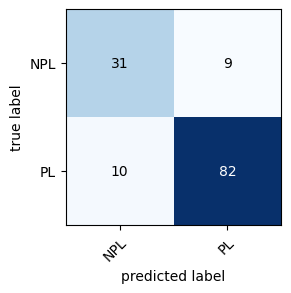

In [27]:
# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='binary')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(4, 2.8)
)

## Model Performance


An epoch is the number of times that the model runs through the entire dataset.
The graphs below will compare this hyperparameter with two different indicators of how well our model works.

### Epochs vs. Loss

Loss is the summation of errors that our model produces. This graph will compare the training loss and the testing loss as the number of epochs increases. A model with a lower loss is considered better than one with a higher loss.

### Epochs vs. Accuracy

Accuracy is the number of images our model correctly identifies. This graph will compare the training and testing accuracy as the number of epochs increases. The higher the accuracy, the better the model.

We are creating these graphs in order to determine the best number of epochs to use when testing and training our images. The goal is to find an epoch in which the accuracy is high and loss is low while also avoiding overfitting. Overfitting can occur when a model is trained on the same images too many times and has trouble predicting images outside of the training dataset. 

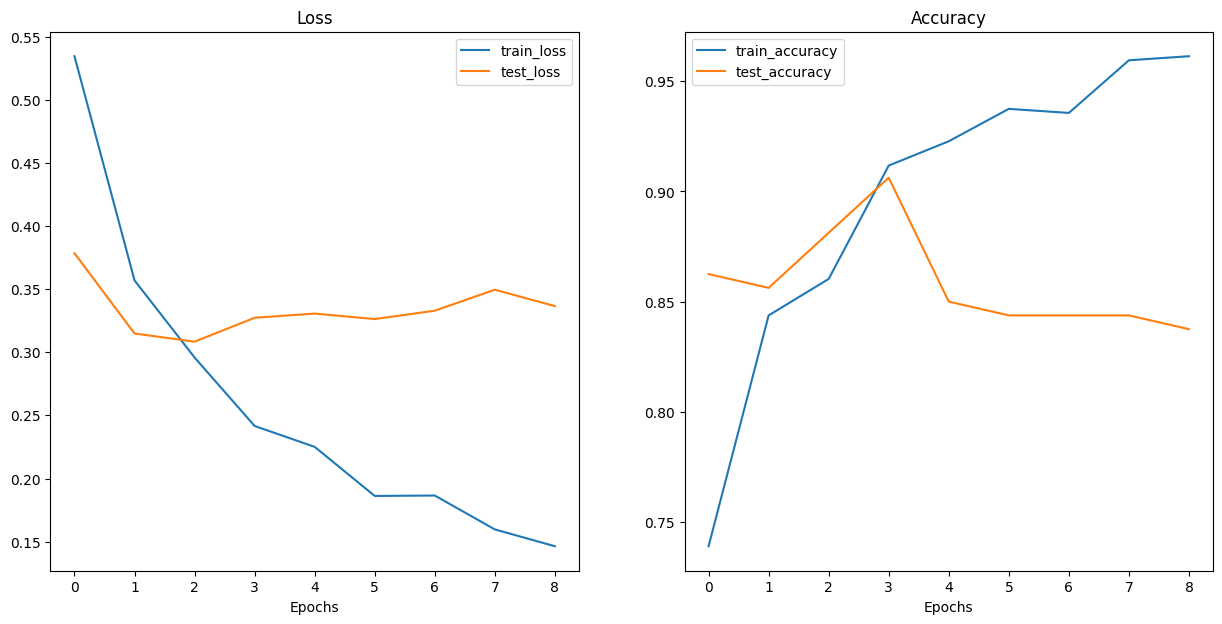

In [28]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_results)


According to the graph, the testing loss doesn’t change much as the number of epochs increases, however, the training loss decreases significantly. Additionally, testing accuracy decreases slightly as the number of epochs increases, however, the training accuracy increases significantly.

From the graphs we can conclude to not run our model with more than 5 epochs for two reasons:

Since AlexNet is a pre-trained CNN, a large number of epochs is not necessary to train the model on our dataset

When we train the model with a larger number of epochs, it begins to overfit, possibly because of the smaller size of our dataset

# Data for Decision Tree

This code turns our model predictions into a dictionary with the image path,	class name,	predition probability,	prediction class, and if it was correctly classified. 

In [60]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]
print(test_data_paths)
print(test_labels)

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path).convert('RGB') # open image, added .convert to match tensor sizes
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[-5:] # show portion of list of dictionaries

[PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 190901_GR1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 200813_HS1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180602_MG2.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180724_RM2.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 190919_SK1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180625_JH2.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 190424_VL4.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180719_IN7.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180909_EU1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 201111_JW1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/Al

  0%|          | 0/132 [00:00<?, ?it/s]

[{'image_path': PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/NPL/Copy of 190914_GR1.png'),
  'class_name': 'NPL',
  'pred_prob': 0.7574030756950378,
  'pred_class': 'NPL',
  'correct': True},
 {'image_path': PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/NPL/Copy of 200307_JL7.png'),
  'class_name': 'NPL',
  'pred_prob': 0.6319065093994141,
  'pred_class': 'PL',
  'correct': False},
 {'image_path': PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/NPL/Copy of 200306_JL6.png'),
  'class_name': 'NPL',
  'pred_prob': 0.6029068827629089,
  'pred_class': 'NPL',
  'correct': True},
 {'image_path': PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/NPL/Copy of 230406_SP1.png'),
  'class_name': 'NPL',
  'pred_prob': 0.6028664112091064,
  'pred_class': 'PL',
  'correct': False},
 {'image_path': PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/NPL/Copy of 201111_JW3.png'),
  'class_name': 'NPL',
  'pred_prob'

In [ ]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

In [64]:
# Get file names of files tested by AlexNet

paths = test_pred_df['image_path'].tolist()
print(paths)

stringFilePaths = []
for i in paths:
  stringPath = str(i)
  filePath = os.path.basename(stringPath)
  stringFilePaths.append(filePath[8:])

print(stringFilePaths)

[PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 190901_GR1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 200813_HS1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180602_MG2.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180724_RM2.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 190919_SK1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180625_JH2.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 190424_VL4.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180719_IN7.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 180909_EU1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/All_Images/testing/PL/Copy of 201111_JW1.png'), PosixPath('/content/drive/My Drive/Bitcamp2023/Al

In [ ]:
# Get dataframe with data associated with each file tested by AlexNet

rowIndicesNeeded = []
for i in stringFilePaths:
  rowIndicesNeeded.append(df[df['file name of PNG'] == i].index[0])

print(rowIndicesNeeded)
print("Amount of rows in df: " + str(len(rowIndicesNeeded)))

df_testing = pd.DataFrame()

for i in rowIndicesNeeded:
  df_testing = df_testing.append(df.iloc[i])

df_testing.reset_index(inplace=True, drop=True)
df_testing = df_testing[["longitude of box right side", "latitude of box top", "file name of PNG", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]

df_testing.head()

##Decision Tree Implementation

The decision tree was created to further classify the images based on the latitude and longitude of the image. For a polar low to be considered a polar low, it has to be either above 40 latitudes or below -40 latitudes. We thought that through creating a decision tree, we would be able to fine tune our model based on the definition of a polar low. our goal was to improve the accuracy from just using Alexnet alone. 

After running AlexNet and classifying the images, we ran the AlexNet image predictions, stored in an array named “master”, through our decision tree. For the depth of our decision tree, we made it equal to 2 to avoid overfitting data. 

In [79]:
prediction_array = [[]]
i = 0

#temp_df is what we use later in order to train our decision tree
#used df_testing which contains data associated with images tested in AlexNet
#also used the true classification labels in temp_df
temp_df = df_testing[["latitude of box top", "longitude of box right side", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]
list_long = list(temp_df["longitude of box right side"])
list_lat = list(temp_df["latitude of box top"])
#turns all the 2's into 1's so it is either 0 or 1, this is because polar lows are classified as both 2 and 1.
#later, we can just use 0 and 1. using 0, 1, and 2, makes things redundant and matches up with the models classification labels. 
list_class = np.array(list(temp_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']))
list_class = np.where(list_class == 2, 1, list_class)

#master is an array that will be passed into the decision tree containing the AlexNet predictions, 
#latitude data, and longitude data. 
master = []
#for all the images in all the lists: long, lat, and prediction, makes it into 1 still
for i in range(len(test_preds)):
  master.append([test_preds[i], float(list_long[i]), float(list_lat[i])])
print(master)

[[tensor(0), 5.732601079, 70.24288221], [tensor(0), -58.41, -53.31], [tensor(0), -10.7558, 53.0721], [tensor(0), 122.1478, 64.7946], [tensor(0), -50.71477907, -41.90928128], [tensor(0), 179.7803, -46.4502], [tensor(0), -16.1719, 55.3359], [tensor(0), -32.7352, 107.7523], [tensor(0), -129.8861, 55.1063], [tensor(0), 144.7543, -40.0277], [tensor(1), -69.9701, -56.7218], [tensor(0), -138.0295, 60.0808], [tensor(0), -16.7922, 62.2947], [tensor(1), 118.8193, -52.5674], [tensor(0), 33.7384, -54.1125], [tensor(0), -89.5054, -53.1572], [tensor(1), 150.2754, 61.3916], [tensor(1), -105.3919, -57.141], [tensor(0), -100.8938, -56.1678], [tensor(1), -5.0867, -40.0347], [tensor(1), -142.7567, 49.5112], [tensor(1), 140.916, -53.021], [tensor(0), 152.0314, -47.9222], [tensor(0), -144.555, -57.94], [tensor(0), -81.8586, -48.7855], [tensor(0), 161.2761, -47.6964], [tensor(0), -75.8646, -48.7035], [tensor(0), 149.1628, -47.9645], [tensor(0), -116.1654, -49.3514], [tensor(0), 163.9228, 52.7026], [tensor(0

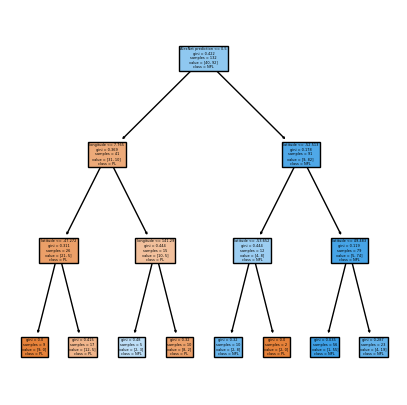

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt  # Matplotlib will allow us to make visuals of our data and display images

#creates a tree of depth 2, if we have too many depths, it overfits (meaning it 
#trains so well that it only does well on the actual training set) 
#generalization: applying trained model to test data
# the tree is a decision maker, it goes down a path to determine the decision. 
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(master, test_truth) # fitting tree with AlexNet predictions and truth labels
fig = plt.figure(figsize=(5,5))
_ = tree.plot_tree(clf, feature_names=['AlexNet prediction', 'longitude', 'latitude'], class_names=['PL', 'NPL'], filled=True)

In [94]:
# test set process
# for a test set, we used the 2022 data as the training data
# we made a confusion matrix
temp_df = df_testing[["latitude of box top", "longitude of box right side", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]
list_long = list(temp_df["longitude of box right side"])
list_lat = list(temp_df["latitude of box top"])
list_class = np.array(list(temp_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']))
list_class = np.where(list_class == 2, 1, list_class)
test_Y = list(list_class.astype(int))

test_X = []
i = 0
for i in range(len(list_long)):
  tmp_lst = [int(list_class[i]), float(list_long[i]), float(list_lat[i])]
  test_X.append(tmp_lst)

pr = clf.predict(test_X)
pr = pr.tolist()

A confusion matrix is created to determine the accuracy of the AlexNet model including the decision tree. The Confusion matrix displays the number of correctly and incorrectly classified polar lows images and the number of correctly and incorrectly classified non-polar lows images. From the confusion matrix, it can be concluded that the accuracy of the model is 93.5%.

The accuracy score of the model is 0.9166666666666666
The precision score for predicting polar lows is 0.9047619047619048
The precision score for predicting non-polar lows is 0.9222222222222223


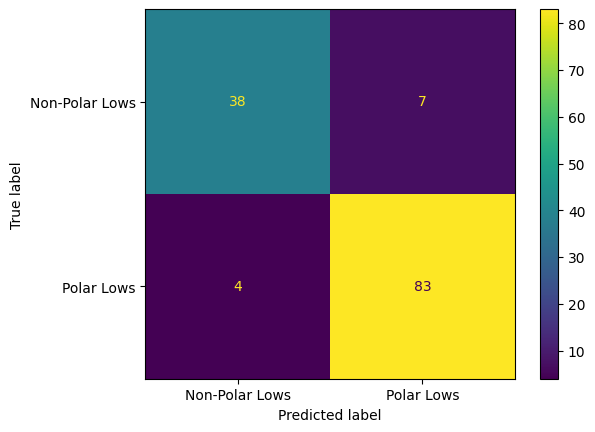

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
#AlexNet results. 
cm = confusion_matrix(test_Y, pr, labels=[0, 1])

#Accuracy Score
y_pred = pr

accuracy = accuracy_score(test_Y,pr)

print("The accuracy score of the model is " + str(accuracy))

#Precision Score
precision = precision_score(test_Y, pr, average=None)

print("The precision score for predicting polar lows is " + str(precision[0]))
print("The precision score for predicting non-polar lows is " + str(precision[1]))

#Displaying the Confusion Matrix
## Used defined labels from labels.txt in the converted_keras folder in the drive
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Polar Lows', 'Polar Lows'])
disp.plot()
plt.show()

#Final Results and Conclusions

Our team consisting of Ryan, Riya, Katie, and Shraddha implemented the AlexNet CNN model and re-trained it with 5 epochs and a learning rate of 0.001. The raw predictions from this model were fed into the decision tree that was created in Spring 2022. The accuracy of Alexnet alone improved the classification of polar lows from the teachable machine from 73% to around **81%**. When implementing the decision tree, the model further improved to **100%**. We were a bit skeptical that the final result was 100%. This overestimated accuracy may have been due to a low amount of testing data - we only used 139 images to feed into the decision tree.  

After looking at the training and testing split data, we found a few images that were mislabeled in the data frame, duplicates, or in the wrong folder. This messed up the 80-20 training testing split for both the non-polar low and polar low images. Additionally, some of the images manually classified as polar lows were incorrectly classified because the latitudes of those images did not fall in the regions where polar lows occur.

For my hack, I cleaned up the dataset by removing any images classified as Polar Low images that were in the incorrect latitude range and added some more images to the non-polar low image dataset. Additionally, for AlexNet, I changed the learning rate to 0.1 and number of epochs to 7 because this combination of parameters led to an optimally low loss and high accuracy. When using AlexNet alone on the dataset, the overall accuracy of the model is **84.3%**. This is an improvement from the previous version of this research, likely because of the larger dataset. For the decision tree, I changed the depth of the tree from 2 to 3 to avoid underfitting. The resulting model has a **91.67%** accuracy overall.